In [1]:
import random
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

 - https://stackoverflow.com/questions/55255633/on-monte-carlo-probability-syntax
 - https://www.wolframalpha.com/input/?i=(3%5E3)+%2F+(4%5E2)
 - https://www.wolframalpha.com/input/?i=(3%2F4)%5E3
 
 ## Demo
 
 - [C(4,1)*C(15,3)-C(4,2)*C(10,3)+C(4,3)*C(5,3)-C(4,4)*C(0,3)](https://www.wolframalpha.com/input/?i=C(4,1)*C(15,3)-C(4,2)*C(10,3)%2BC(4,3)*C(5,3)-C(4,4)*C(0,3))

In [2]:
perms = list(itertools.permutations("ooo|||"))
len(perms)

720

In [3]:
noA = sum([int(x[0] == '|') for x in perms])
noA

360

In [4]:
c = np.array([1]*3+[0]*17)

In [5]:
import random
import collections

def runMonteCarlo(nw=3, nh=20, nt=4, N=20):
    """
    Run Monte Carlo Simulation
    """
    
    def countWomen(c, nt=4):
        """
        Count Number of Women per Table
        """
        x = np.array(c).reshape(nt, -1).T
        return np.sum(x, axis=0)
    
    # Initialization:
    comp = np.array([1]*nw + [0]*(nh-nw)) # Composition: 1=woman, 0=man
    x = []                                # Counts of tables without any woman
    p = 0                                 # Probability of there is no woman at table A  
    
    for k in range(N):
        c = np.random.permutation(comp)   # Random permutation, table composition
        w = countWomen(c, nt=nt)          # Count Woman per table
        nc = np.sum(w!=0)                 # Count how many tables with women 
        x.append(nt - nc)                 # Store count of tables without any woman
        p += int(w[0]==0)                 # Is table A empty?
        #if k % 100 == 0:
            #print(c, w, nc, nt-nc, p)
    
    # Rationalize (count->frequency)
    r = collections.Counter(x)
    r = {k:r.get(k, 0)/N for k in range(nt+1)}
    p /= N
    return r, p

In [6]:
s = runMonteCarlo(c, N=10000)
s

({0: 0.0, 1: 0.4418, 2: 0.5221, 3: 0.0361, 4: 0.0}, 0.3982)

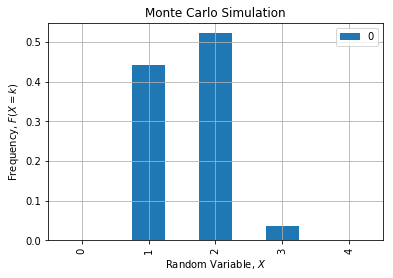

In [7]:
axe = pd.DataFrame.from_dict(s[0], orient='index').plot(kind='bar')
axe.set_title("Monte Carlo Simulation")
axe.set_xlabel('Random Variable, $X$')
axe.set_ylabel('Frequency, $F(X=k)$')
axe.grid()

In [8]:
sum([k*v for k,v in s[0].items()])

1.5943

In [9]:
for n in [100, 1000, 10000]:
    s = runMonteCarlo(N=n)
    E = sum([k*v for k,v in s[0].items()])
    print('N=%d, P(X=k) = %s, p=%s, E[X]=%s' % (n, *s, E))

N=100, P(X=k) = {0: 0.0, 1: 0.36, 2: 0.6, 3: 0.04, 4: 0.0}, p=0.41, E[X]=1.6800000000000002
N=1000, P(X=k) = {0: 0.0, 1: 0.435, 2: 0.519, 3: 0.046, 4: 0.0}, p=0.426, E[X]=1.6110000000000002
N=10000, P(X=k) = {0: 0.0, 1: 0.4378, 2: 0.527, 3: 0.0352, 4: 0.0}, p=0.392, E[X]=1.5974


In [10]:
def runMonteCarlo2(nw=3, nh=20, nt=4, N=20):
    """
    Run Monte Carlo Simulation
    """
    
    def one_experiment(nt, nw):
        """Draw a table plan (Credit to @Inon Peled)"""
        return set(random.randint(0, nt-1) for _ in range(nw)) # Sample nw times from 0 <= k <= nt-1
    
    c = collections.Counter()             # Empty Table counter
    p = 0                                 # Probability of there is no woman at table A  
    
    for k in range(N):
        exp = one_experiment(nt, nw)      # Select table with at least one woman
        c.update([nt - len(exp)])         # Update Counter X distribution
        p += int(0 not in exp)            # There is no woman at table A (table 0)
    
    # Rationalize:
    r = {k:c.get(k, 0)/N for k in range(nt+1)}
    p /= N
    
    return r, p

In [11]:
def runMonteCarlo3(n=3, p=5, m=4, N=100):
    """
    Run Monte Carlo Simulation:
    
    Setup:
    
      - m*p persons are mapped to m tables of capacity p.
      - There are exactly n women. 
    
    Assess the distribution of X (number of tables where no woman sit), where:
    
      - n (int), number of women;
      - p (int), number of persons per table;
      - m (int), number of tables;
      - N (int), number of Monte Carlo simulations.
      
    Returns:
    
      - r (dict of (int, float)), experimental distribution of X;
      - f (float), probability of no woman sitting at table A.
    """
    
    def draw(c, n, p):
        """
        Draw a random Monte Carlo Input for the given problem:
        
          - Draw n elements without replacement from the set {0, m*p-1} (select woman place indices)
          - Perform floor division of the n elements by p (assess table indices from place indices)
          - Returns a set of place indices where women sit.
        """
        return {x//p for x in random.sample(c, n)}
    
    # Initialization
    places = list(range(m*p))             # Place indices: set {0, m*p-1}
    C = {k:0 for k in range(m+1)}         # Table without women Counter      
    f = 0                                 # Frequency of: There is no woman sitting at table A  
    
    # Generate Monte-Carlo Inputs and aggregate Outputs
    for k in range(N):
        e = draw(places, n, p)            # Draw a random experiment
        x = m - len(e)                    # Number of table without woman
        C[x] += 1                         # Update Counter for X distribution
        f += int(0 not in e)              # Is there no woman at table A (index 0)?
    
    # Rationalization (convert Counts to Frequencies)
    r = {k:v/N for (k,v) in C.items()}
    f /= N
    
    return r, f

In [23]:
for n in [100, 1000, 10000]:
    s = runMonteCarlo3(N=n)
    E = sum([k*v for k,v in s[0].items()])
    print('N=%d, P(X=k) = %s, p=%s, E[X]=%s' % (n, *s, E))

N=100, P(X=k) = {0: 0.0, 1: 0.43, 2: 0.54, 3: 0.03, 4: 0.0}, p=0.36, E[X]=1.6
N=1000, P(X=k) = {0: 0.0, 1: 0.407, 2: 0.556, 3: 0.037, 4: 0.0}, p=0.42, E[X]=1.6300000000000001
N=10000, P(X=k) = {0: 0.0, 1: 0.4408, 2: 0.5284, 3: 0.0308, 4: 0.0}, p=0.3937, E[X]=1.59


In [12]:
d = []
for f in [runMonteCarlo, runMonteCarlo2, runMonteCarlo3]:
    for n in np.arange(100, 10001, 100):
        s = f(N=n)
        E = sum([k*v for k,v in s[0].items()])
        d.append(dict(f=f.__name__, N=n, **{'P(X=%d)' %k:s[0][k] for k in s[0]}, E=E, p=s[1]))
        print('N=%d, P(X=k) = %s, p=%s, E[X]=%s' % (n, *s, E))

N=100, P(X=k) = {0: 0.0, 1: 0.43, 2: 0.56, 3: 0.01, 4: 0.0}, p=0.36, E[X]=1.58
N=200, P(X=k) = {0: 0.0, 1: 0.465, 2: 0.51, 3: 0.025, 4: 0.0}, p=0.39, E[X]=1.56
N=300, P(X=k) = {0: 0.0, 1: 0.43, 2: 0.52, 3: 0.05, 4: 0.0}, p=0.4033333333333333, E[X]=1.62
N=400, P(X=k) = {0: 0.0, 1: 0.4825, 2: 0.4775, 3: 0.04, 4: 0.0}, p=0.4725, E[X]=1.5575
N=500, P(X=k) = {0: 0.0, 1: 0.48, 2: 0.488, 3: 0.032, 4: 0.0}, p=0.372, E[X]=1.552
N=600, P(X=k) = {0: 0.0, 1: 0.4116666666666667, 2: 0.5533333333333333, 3: 0.035, 4: 0.0}, p=0.40166666666666667, E[X]=1.6233333333333333
N=700, P(X=k) = {0: 0.0, 1: 0.43142857142857144, 2: 0.5328571428571428, 3: 0.03571428571428571, 4: 0.0}, p=0.4057142857142857, E[X]=1.6042857142857143
N=800, P(X=k) = {0: 0.0, 1: 0.4625, 2: 0.51, 3: 0.0275, 4: 0.0}, p=0.38, E[X]=1.565
N=900, P(X=k) = {0: 0.0, 1: 0.44333333333333336, 2: 0.5311111111111111, 3: 0.025555555555555557, 4: 0.0}, p=0.39222222222222225, E[X]=1.5822222222222222
N=1000, P(X=k) = {0: 0.0, 1: 0.438, 2: 0.538, 3: 0.0

N=6200, P(X=k) = {0: 0.0, 1: 0.43048387096774193, 2: 0.5359677419354839, 3: 0.03354838709677419, 4: 0.0}, p=0.40306451612903227, E[X]=1.6030645161290322
N=6300, P(X=k) = {0: 0.0, 1: 0.44063492063492066, 2: 0.5236507936507937, 3: 0.03571428571428571, 4: 0.0}, p=0.40825396825396826, E[X]=1.5950793650793653
N=6400, P(X=k) = {0: 0.0, 1: 0.44046875, 2: 0.526875, 3: 0.03265625, 4: 0.0}, p=0.40109375, E[X]=1.5921874999999999
N=6500, P(X=k) = {0: 0.0, 1: 0.4452307692307692, 2: 0.5163076923076924, 3: 0.038461538461538464, 4: 0.0}, p=0.398, E[X]=1.5932307692307695
N=6600, P(X=k) = {0: 0.0, 1: 0.43242424242424243, 2: 0.5322727272727272, 3: 0.0353030303030303, 4: 0.0}, p=0.40636363636363637, E[X]=1.6028787878787878
N=6700, P(X=k) = {0: 0.0, 1: 0.43477611940298505, 2: 0.5302985074626866, 3: 0.03492537313432836, 4: 0.0}, p=0.3977611940298508, E[X]=1.6001492537313433
N=6800, P(X=k) = {0: 0.0, 1: 0.4577941176470588, 2: 0.5089705882352941, 3: 0.03323529411764706, 4: 0.0}, p=0.40147058823529413, E[X]=1.

N=3100, P(X=k) = {0: 0.0, 1: 0.3790322580645161, 2: 0.5593548387096774, 3: 0.061612903225806454, 4: 0.0}, p=0.4206451612903226, E[X]=1.6825806451612901
N=3200, P(X=k) = {0: 0.0, 1: 0.37, 2: 0.5671875, 3: 0.0628125, 4: 0.0}, p=0.4290625, E[X]=1.6928125
N=3300, P(X=k) = {0: 0.0, 1: 0.36666666666666664, 2: 0.5654545454545454, 3: 0.06787878787878789, 4: 0.0}, p=0.43303030303030304, E[X]=1.7012121212121212
N=3400, P(X=k) = {0: 0.0, 1: 0.37176470588235294, 2: 0.5685294117647058, 3: 0.05970588235294118, 4: 0.0}, p=0.42, E[X]=1.6879411764705883
N=3500, P(X=k) = {0: 0.0, 1: 0.37257142857142855, 2: 0.5682857142857143, 3: 0.05914285714285714, 4: 0.0}, p=0.42114285714285715, E[X]=1.6865714285714286
N=3600, P(X=k) = {0: 0.0, 1: 0.38027777777777777, 2: 0.5533333333333333, 3: 0.06638888888888889, 4: 0.0}, p=0.42583333333333334, E[X]=1.6861111111111111
N=3700, P(X=k) = {0: 0.0, 1: 0.37405405405405406, 2: 0.5613513513513514, 3: 0.0645945945945946, 4: 0.0}, p=0.42027027027027025, E[X]=1.6905405405405407

N=8800, P(X=k) = {0: 0.0, 1: 0.37681818181818183, 2: 0.5621590909090909, 3: 0.06102272727272727, 4: 0.0}, p=0.41613636363636364, E[X]=1.6842045454545453
N=8900, P(X=k) = {0: 0.0, 1: 0.37359550561797755, 2: 0.5620224719101123, 3: 0.06438202247191012, 4: 0.0}, p=0.4237078651685393, E[X]=1.6907865168539327
N=9000, P(X=k) = {0: 0.0, 1: 0.37044444444444447, 2: 0.5653333333333334, 3: 0.06422222222222222, 4: 0.0}, p=0.4262222222222222, E[X]=1.693777777777778
N=9100, P(X=k) = {0: 0.0, 1: 0.369010989010989, 2: 0.5678021978021978, 3: 0.06318681318681318, 4: 0.0}, p=0.4197802197802198, E[X]=1.694175824175824
N=9200, P(X=k) = {0: 0.0, 1: 0.3726086956521739, 2: 0.5606521739130435, 3: 0.0667391304347826, 4: 0.0}, p=0.42619565217391303, E[X]=1.6941304347826087
N=9300, P(X=k) = {0: 0.0, 1: 0.36516129032258066, 2: 0.5740860215053764, 3: 0.06075268817204301, 4: 0.0}, p=0.4281720430107527, E[X]=1.6955913978494626
N=9400, P(X=k) = {0: 0.0, 1: 0.37117021276595746, 2: 0.5685106382978723, 3: 0.06031914893617

N=4900, P(X=k) = {0: 0.0, 1: 0.4275510204081633, 2: 0.5355102040816326, 3: 0.03693877551020408, 4: 0.0}, p=0.413265306122449, E[X]=1.6093877551020408
N=5000, P(X=k) = {0: 0.0, 1: 0.4318, 2: 0.5366, 3: 0.0316, 4: 0.0}, p=0.4034, E[X]=1.5997999999999999
N=5100, P(X=k) = {0: 0.0, 1: 0.4441176470588235, 2: 0.5219607843137255, 3: 0.03392156862745098, 4: 0.0}, p=0.39862745098039215, E[X]=1.5898039215686275
N=5200, P(X=k) = {0: 0.0, 1: 0.43576923076923074, 2: 0.5276923076923077, 3: 0.03653846153846154, 4: 0.0}, p=0.40076923076923077, E[X]=1.6007692307692307
N=5300, P(X=k) = {0: 0.0, 1: 0.43471698113207546, 2: 0.5330188679245284, 3: 0.03226415094339623, 4: 0.0}, p=0.40169811320754717, E[X]=1.5975471698113208
N=5400, P(X=k) = {0: 0.0, 1: 0.447037037037037, 2: 0.5198148148148148, 3: 0.03314814814814815, 4: 0.0}, p=0.3894444444444444, E[X]=1.5861111111111112
N=5500, P(X=k) = {0: 0.0, 1: 0.4290909090909091, 2: 0.5325454545454545, 3: 0.038363636363636364, 4: 0.0}, p=0.3998181818181818, E[X]=1.60927

In [13]:
df = pd.DataFrame(d)
df.tail()

,E,N,P(X=0),P(X=1),P(X=2),P(X=3),P(X=4),f,p
295,1.600417,9600,0.0,0.435937,0.527708,0.036354,0.0,runMonteCarlo3,0.400521
296,1.596598,9700,0.0,0.439175,0.525052,0.035773,0.0,runMonteCarlo3,0.398557
297,1.601327,9800,0.0,0.433469,0.531735,0.034796,0.0,runMonteCarlo3,0.400102
298,1.596061,9900,0.0,0.443131,0.517677,0.039192,0.0,runMonteCarlo3,0.392525
299,1.593600,10000,0.0,0.440000,0.526400,0.033600,0.0,runMonteCarlo3,0.395100


In [14]:
df2 = df.set_index(['N', 'f']).unstack()

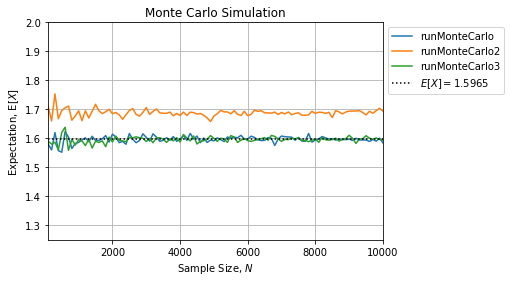

In [15]:
axe = df2['E'].plot()
axe.axhline(91/57, label=r'$E[X] = %.4f$' % (91/57), linestyle=':', color='k')
axe.set_ylim([1.25, 2])
axe.set_title("Monte Carlo Simulation")
axe.set_xlabel(r"Sample Size, $N$")
axe.set_ylabel(r"Expectation, $\mathrm{E}[X]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

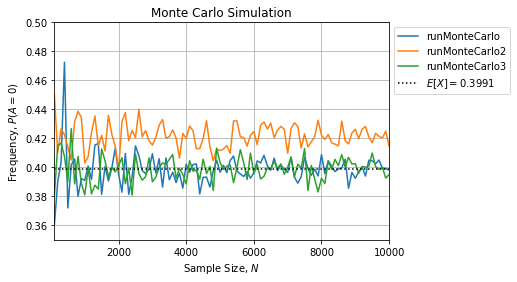

In [16]:
axe = df2['p'].plot()
axe.axhline(91/228, label=r'$E[X] = %.4f$' % (91/228), linestyle=':', color='k')
axe.set_ylim([0.35, 0.50])
axe.set_title("Monte Carlo Simulation")
axe.set_xlabel(r"Sample Size, $N$")
axe.set_ylabel(r"Frequency, $P(A=0)$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

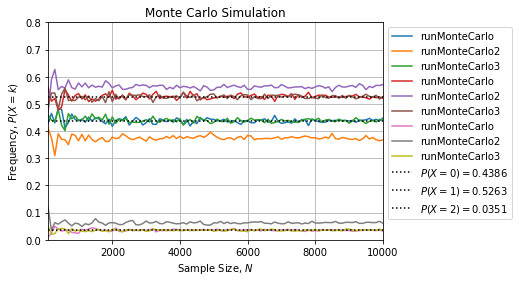

In [17]:
fig, axe = plt.subplots()
for i in range(3):
    k = 'P(X=%d)'%(i+1)
    df2[k].plot(ax=axe)
    #axe.text(5000,(i)*0.25+0.05, k)
    
for i,k in enumerate([25/57,10/19,2/57]):
    axe.axhline(k, label=r'$P(X=%d) = %.4f$' % (i,k), linestyle=':', color='k')

axe.set_ylim([0, 0.8])
axe.set_title("Monte Carlo Simulation")
axe.set_xlabel(r"Sample Size, $N$")
axe.set_ylabel(r"Frequency, $P(X=k)$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

In [18]:
print(df2.swaplevel(axis=1).loc[::21,pd.IndexSlice[:,'E']].to_latex())

\begin{tabular}{lrrr}
\toprule
f & runMonteCarlo & runMonteCarlo2 & runMonteCarlo3 \\
{} &             E &              E &              E \\
N    &               &                &                \\
\midrule
100  &      1.580000 &       1.710000 &       1.590000 \\
2200 &      1.585000 &       1.681364 &       1.593636 \\
4300 &      1.616977 &       1.690465 &       1.591163 \\
6400 &      1.592187 &       1.695469 &       1.598750 \\
8500 &      1.598824 &       1.671765 &       1.595765 \\
\bottomrule
\end{tabular}



In [19]:
df2.loc[10000,:]

        f             
E       runMonteCarlo     1.5840
        runMonteCarlo2    1.6933
        runMonteCarlo3    1.5936
P(X=0)  runMonteCarlo     0.0000
        runMonteCarlo2    0.0000
        runMonteCarlo3    0.0000
P(X=1)  runMonteCarlo     0.4477
        runMonteCarlo2    0.3678
        runMonteCarlo3    0.4400
P(X=2)  runMonteCarlo     0.5206
        runMonteCarlo2    0.5711
        runMonteCarlo3    0.5264
P(X=3)  runMonteCarlo     0.0317
        runMonteCarlo2    0.0611
        runMonteCarlo3    0.0336
P(X=4)  runMonteCarlo     0.0000
        runMonteCarlo2    0.0000
        runMonteCarlo3    0.0000
p       runMonteCarlo     0.3981
        runMonteCarlo2    0.4146
        runMonteCarlo3    0.3951
Name: 10000, dtype: float64

If we consider the problem as a locker with 4 symbols (A, B, C, D) and 3 digits, then there is $\# \Omega = 4^3 = 64$ possible setups.

Then we can assess $P(X=k)$ using combinatorics:

$$
\begin{align}
P(X=0) &= 0 \\
P(X=1) &= \frac{C^1_4 C^1_3 C^1_2}{4^3} = \frac{24}{64} = 0.375 \\
P(X=2) &= \frac{C^1_4 C^1_3 C^2_3}{4^3} = \frac{36}{64} = 0.5625\\
P(X=3) &= \frac{C^1_4}{4^3} = \frac{4}{64} = 0.0625 \\
P(X=4) &= 0 
\end{align}
$$

The expectation of $X$ is:

$$
\mathrm{E}[X] = \frac{24}{64} + 2\frac{36}{64} + 3\frac{4}{64} = \frac{27}{16} = 1.6875
$$

And the probability of having no woman at the table A is then:

$$
P(A=0) = \frac{3^3}{4^3} = \frac{27}{64} = 0.421875
$$

In [20]:
C = collections.Counter({0:5, 1:10, 2:15})

In [21]:
dict(C)/5

TypeError: unsupported operand type(s) for /: 'dict' and 'int'